Data from Kaggle:

https://www.kaggle.com/antfarol/car-sale-advertisements

https://www.kaggle.com/satadru5/car-sale-prediction

# 1. Importing the relevant libraries

In [160]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

# 2. Common function

In [161]:
def Predictive_Model(num_df, cat_df, target):
    
    # scaling features for numerical vars
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(num_df)
    input_df = scaler.transform(num_df)
    input_df = pd.DataFrame(input_df, columns = num_df.columns)
    
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = pd.concat([input_df,cat_df],axis=1)
        
    # train test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, target, test_size=0.2, random_state=365)
    
    # built model   
    from sklearn import ensemble
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    
    # return result
    print('Train set: ', model.score(X_train, y_train))
    print('Test set: ',model.score(X_test, y_test))
    
    # Get numerical feature importance
    feature_importance = list(model.feature_importances_)
    feature_labels = X_train.columns
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_labels, feature_importance)]
    # Sort the feature importance by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importance 
    [print('{:50} Importance: {}'.format(*pair)) for pair in feature_importances];

In [162]:
# Distribution plot

def analyse_continuous(df,var,target,title):
    df = df.copy()
    df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(21,6))
    plt.subplot(131)
    sns.boxplot(x=df[var])
    plt.title(title)
    plt.subplot(132)
    sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title(title)
    plt.subplot(133)
    plt.scatter(df[var],df[target])
    plt.title(title)
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.title(title)
    plt.show()

# 3. Loading the raw data

In [163]:
raw_data = pd.read_csv('CarSale.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.00,sedan,277,2.00,Petrol,yes,1991,320
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,yes,2003,S 500
3,Audi,23000.00,crossover,240,4.20,Petrol,yes,2007,Q7
4,Toyota,18300.00,crossover,120,2.00,Petrol,yes,2011,Rav 4


This is a list of second hand cars with the respective price of body, mileage, engine volume, engine type, production model and information about the time when they were registered. What we would like to do is predict the price of a used car depending on its specifications. 

    + The first potential aggressor is brand as it is well-known that a BMW is generally more expensive than a Toyota. 
    + The second relevant variable is mileage since the more a car is driven the cheaper it should be. 
    + Third, the engine volume, sports cars have larger engines and economy cars have smaller engines
    + The final variable is year of production, the older the car, the cheaper it is with the exception of vintage vehicles
    + The rest are categorical variables which we'll deal with on a case by case basis

In [164]:
# Let's check the descriptives without 'Model'
data = raw_data.copy()
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4345,7,Volkswagen,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4173.00,NaN,NaN,NaN,19418.75,25584.24,600.00,6999.00,11500.00,21700.00,300000.00
Body,4345,6,sedan,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4345.00,NaN,NaN,NaN,161.24,105.71,0.00,86.00,155.00,230.00,980.00
EngineV,4195.00,NaN,NaN,NaN,2.79,5.07,0.60,1.80,2.20,3.00,99.99
Engine Type,4345,4,Diesel,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4345,2,yes,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4345.00,NaN,NaN,NaN,2006.55,6.72,1969.00,2003.00,2008.00,2012.00,2016.00
Model,4345,312,E-Class,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Dealing with Missing data

### Approach 1: Removing rows with missing values

A rule of thumb is that if you are removing less than 5 percent of observations, you are free to just remove all observations that have missing values. In this case they are less than that, so we are safe

In [165]:
# Lest's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
df_missing_data = data.copy()
data = data.dropna(axis=0)
data.reset_index(drop=True,inplace=True)
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4025,7,Volkswagen,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4025.00,NaN,NaN,NaN,19552.31,25815.73,600.00,6999.00,11500.00,21900.00,300000.00
Body,4025,6,sedan,1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4025.00,NaN,NaN,NaN,163.57,103.39,0.00,90.00,158.00,230.00,980.00
EngineV,4025.00,NaN,NaN,NaN,2.76,4.94,0.60,1.80,2.20,3.00,99.99
Engine Type,4025,4,Diesel,1861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4025,2,yes,3654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4025.00,NaN,NaN,NaN,2006.38,6.70,1969.00,2003.00,2007.00,2012.00,2016.00
Model,4025,306,E-Class,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Approach 2: Replacing missing values with mean/median

### Approach 3: Adding a binary col to indicate there is missing value

# 5. GBT without Preprocessing data

In [166]:
num_df = data[['Mileage','EngineV','Year']]
cat_df = data[['Brand','Body','Engine Type','Registration','Model']]
cat_df = pd.get_dummies(cat_df, drop_first=True)
target = data['Price']

Predictive_Model(num_df, cat_df, target)

Train set:  0.9390649613114997
Test set:  0.9126698223932113
Year                                               Importance: 0.35
EngineV                                            Importance: 0.34
Mileage                                            Importance: 0.13
Brand_Mercedes-Benz                                Importance: 0.05
Model_S 600                                        Importance: 0.03
Model_S-Guard                                      Importance: 0.02
Body_other                                         Importance: 0.01
Model_G 63 AMG                                     Importance: 0.01
Model_Sprinter 324                                 Importance: 0.01
Model_V 250                                        Importance: 0.01
Brand_BMW                                          Importance: 0.0
Brand_Mitsubishi                                   Importance: 0.0
Brand_Renault                                      Importance: 0.0
Brand_Toyota                                       Importa

=> Large number of inputs may cause overfitting problem

In [167]:
num_df = data[['Mileage','EngineV','Year']]
cat_df = data[['Brand','Body','Engine Type','Registration','Model']]
cat_df = pd.get_dummies(cat_df, drop_first=True)
cat_df = cat_df[['Brand_Mercedes-Benz','Model_S 600','Model_S-Guard','Body_other','Model_G 63 AMG','Model_Sprinter 324','Model_V 250']]
target = data['Price']

Predictive_Model(num_df, cat_df, target)

Train set:  0.9128410906444122
Test set:  0.8753375926844408
EngineV                                            Importance: 0.36
Year                                               Importance: 0.36
Mileage                                            Importance: 0.14
Brand_Mercedes-Benz                                Importance: 0.06
Model_S 600                                        Importance: 0.04
Model_S-Guard                                      Importance: 0.02
Model_G 63 AMG                                     Importance: 0.01
Model_Sprinter 324                                 Importance: 0.01
Model_V 250                                        Importance: 0.01
Body_other                                         Importance: 0.0


# 6. Preprocessing data

=> Preprocessing is an important step in Data Analysis which include many techniques to improve the accuracy of the predictive model through understanding data characteristics and preprocess data to fit model's ability

## 6.1. Numerical vars

In [168]:
target_var = 'Price'
num_vars = [var for var in data.columns if data[var].dtypes != 'O' and var != target_var]
target = data['Price']
num_df = data[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Train set:  0.8825812248801225
Test set:  0.8124233512769572
EngineV                                            Importance: 0.43
Year                                               Importance: 0.4
Mileage                                            Importance: 0.17


### Target variable: Price

#### Exploring the PDFs

Notice the minimum and maximum values with respect to the mean and the core tiles for each variable and examine them using the probability distribution functions. Price has a mean around nineteen thousand dollars, the minimum price is six hundred dollars twenty five, twenty five percent of price are under seven thousand dollars, 50 percent below eleven thousand five hundred dollars and seventy five percent are lower than twenty one thousand nine hundred dollars. **Yet the maximum price is three hundred thousand dollars**. Something strange is going on

A great step in the data exploration is to display the probability distribution function (PDF) of a variable. The PDF will show us how that variable is distributed. This makes it very easy to spot anomalies, such as outliers. The PDF is often thee basis on which we decide whether we want to transform a features

Outliers are observations that lie on abnormal distance from observations in the data, they will affect the regression dramatically in cost coefficients to be inflated (thoi phong) as the regression will try to place the line closer to those values. Outliers are a great issue for OLS, thus we must deal with them in some way. 

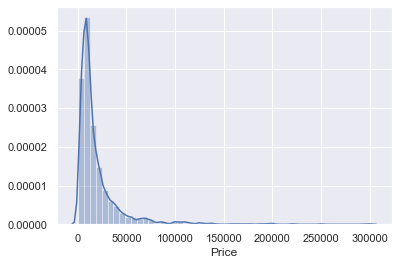

In [169]:
sns.distplot(data['Price'])

For optimal results, we would be looking for a normal distribution price however has an exponential one. This will surely be a problem for our regression. Obviously we have a few outliers in the price variable. 

Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples. Logic should also be applied. This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price

In [170]:
# Declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = data['Price'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = data[data['Price']<q]
data_1.reset_index(drop=True, inplace=True)
# In this way we have essentially remove the top 1% of the data about 'Price'
data_1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,3984,7,Volkswagen,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,3984.00,NaN,NaN,NaN,17837.12,18976.27,600.00,6980.00,11400.00,21000.00,129222.00
Body,3984,6,sedan,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,3984.00,NaN,NaN,NaN,165.12,102.77,0.00,93.00,160.00,230.00,980.00
EngineV,3984.00,NaN,NaN,NaN,2.74,4.96,0.60,1.80,2.20,3.00,99.99
Engine Type,3984,4,Diesel,1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,3984,2,yes,3613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3984.00,NaN,NaN,NaN,2006.29,6.67,1969.00,2002.75,2007.00,2011.00,2016.00
Model,3984,302,E-Class,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN


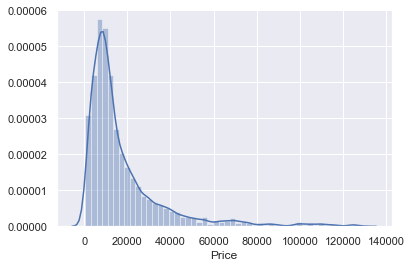

In [171]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers
sns.distplot(data_1['Price'])

The data is still distributed in the same way but with less outliers. We can deal with it in the same way keeping only the data lower than the ninety ninth percentile

In [172]:
num_vars = [var for var in data.columns if data[var].dtypes != 'O' and var != target_var]
target = data_1['Price']
num_df = data_1[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Train set:  0.8749739610395707
Test set:  0.8457244946498728
Year                                               Importance: 0.49
EngineV                                            Importance: 0.38
Mileage                                            Importance: 0.13


### Mileage

Skewness: 0.709469
Kurtosis: 1.883031


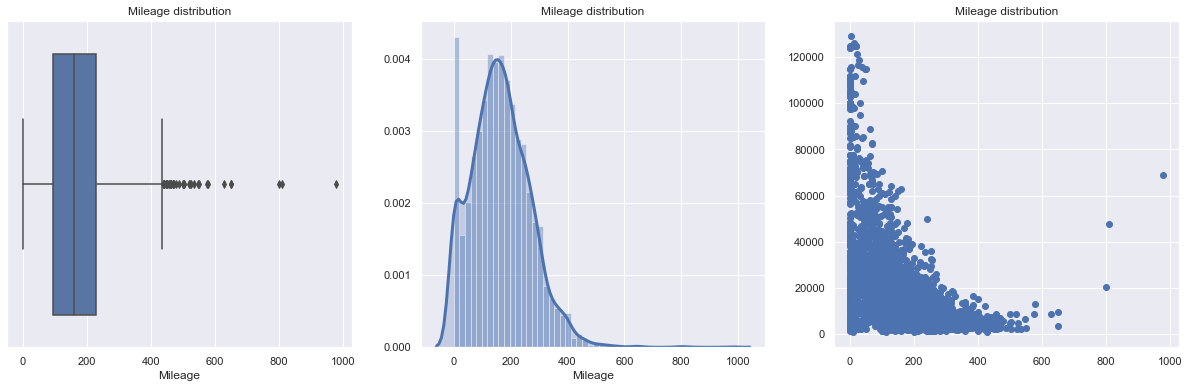

In [173]:
analyse_continuous(data_1,'Mileage',target_var,'Mileage'+' distribution')

The data is still distributed in the same way but with less outliers. We can deal with it in the same way keeping only the data lower than the ninety ninth percentile

In [174]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]
data_2.reset_index(drop=True,inplace=True)

Skewness: 0.265109
Kurtosis: -0.426539


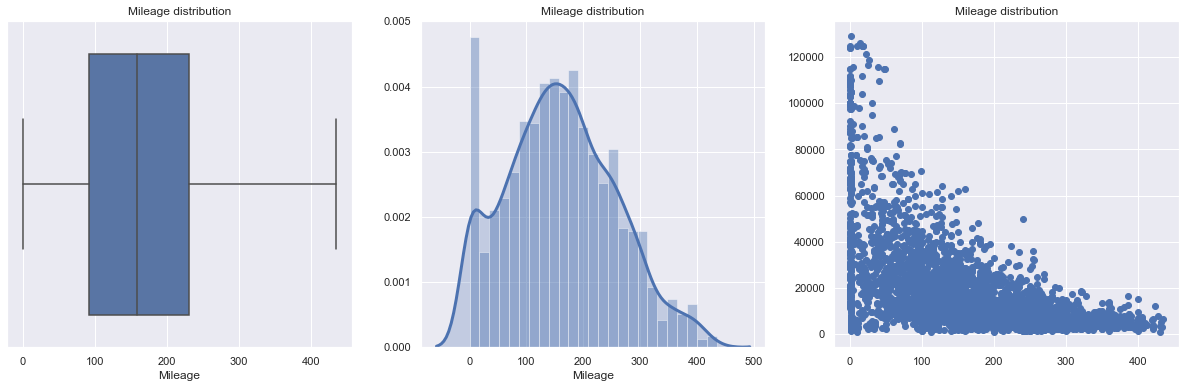

In [175]:
analyse_continuous(data_2,'Mileage',target_var,'Mileage'+' distribution')

In [176]:
target = data_2['Price']
num_df = data_2[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.8726000076433901
Test set:  0.8478756647442071
Year                                               Importance: 0.49
EngineV                                            Importance: 0.38
Mileage                                            Importance: 0.13


### EngineV

Skewness: 17.051901
Kurtosis: 311.502019


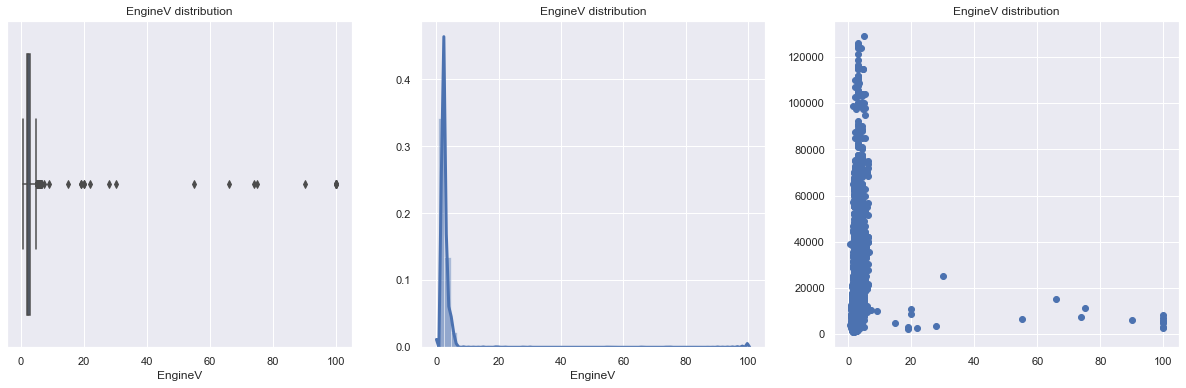

In [177]:
analyse_continuous(data_2,'EngineV',target_var,'EngineV'+' distribution')

In [178]:
# A simple Google search can indicate the natural domain of this variable
# Car engine volumes are usually (always?) below 6.5l
# This is a prime example of the fact that a domain expert (a person working in the car industry)
# may find it much easier to determine problems with the data than an outsider
data_3 = data_2[data_2['EngineV']<6.5]
data_3.reset_index(drop=True,inplace=True)

Skewness: 1.490153
Kurtosis: 2.342794


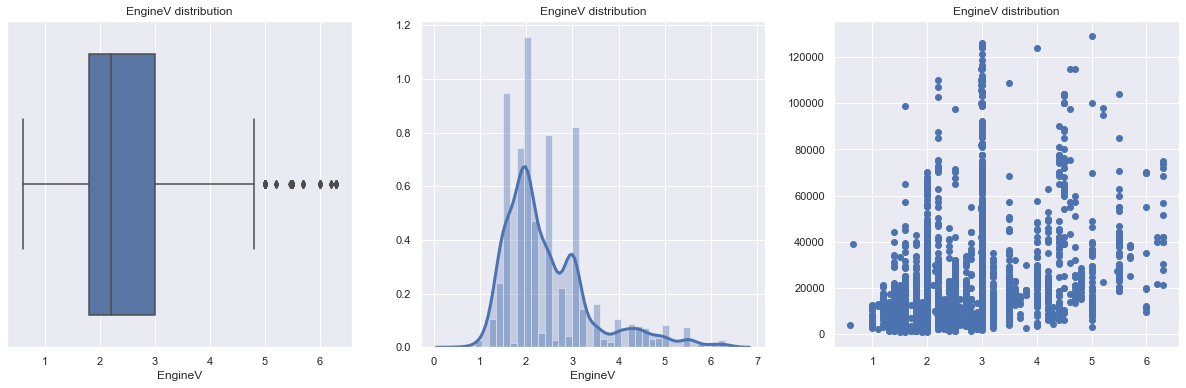

In [179]:
analyse_continuous(data_3,'EngineV',target_var,'EngineV'+' distribution')

Following this graph, we realize we can actually treat EngineV as a categorical variable. Even so, in this course we won't, but that's yet something else you may try on your own

In [180]:
target = data_3['Price']
num_df = data_3[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.8709392910074234
Test set:  0.8608898648637131
Year                                               Importance: 0.49
EngineV                                            Importance: 0.36
Mileage                                            Importance: 0.15


### Year

Skewness: -0.977779
Kurtosis: 1.077789


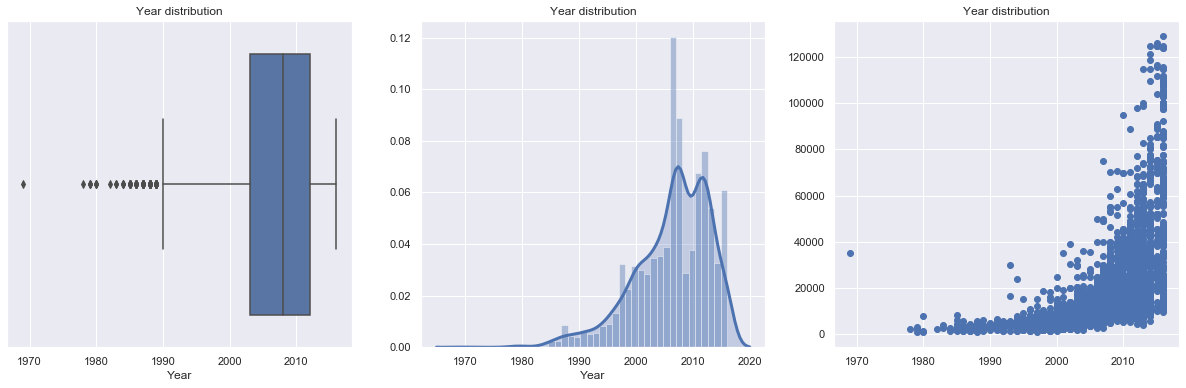

In [181]:
analyse_continuous(data_3,'Year',target_var,'Year'+' distribution')

The problem with year is it's on the low end. Most cars are newer but there seem to be a few vintage cars this time. This time, I'll take the first percentile and the we'll keep all observations that are higher

In [182]:
# I'll simply remove them
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]
data_4.reset_index(drop=True,inplace=True)

Skewness: -0.718794
Kurtosis: 0.109411


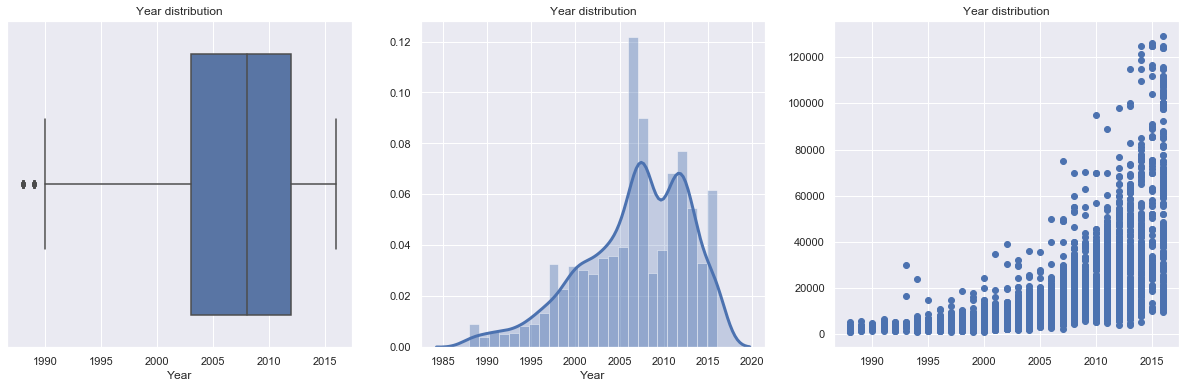

In [183]:
analyse_continuous(data_4,'Year',target_var,'Year'+' distribution')

In [184]:
target = data_4['Price']
num_df = data_4[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.8698586549697299
Test set:  0.8565595524524059
Year                                               Importance: 0.51
EngineV                                            Importance: 0.37
Mileage                                            Importance: 0.12


### Data cleaned

In [185]:
# When we remove observations, the original indexes are preserved
# If we remove observations with indexes 2 and 3, the indexes will go as: 0,1,4,5,6
# That's very problematic as we tend to forget about it (later you will see an example of such a problem)

# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it
data_cleaned = data_4.reset_index(drop=True)

In [186]:
# Let's see what's left
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3867,3867.00,3867,3867.00,3867.00,3867,3867,3867.00,3867
unique,7,nan,6,nan,nan,4,2,nan,291
top,Volkswagen,nan,sedan,nan,nan,Diesel,yes,nan,E-Class
freq,848,nan,1467,nan,nan,1807,3505,nan,181
mean,NaN,18194.46,NaN,160.54,2.45,NaN,NaN,2006.71,NaN
std,NaN,19085.86,NaN,95.63,0.95,NaN,NaN,6.10,NaN
min,NaN,800.00,NaN,0.00,0.60,NaN,NaN,1988.00,NaN
25%,NaN,7200.00,NaN,91.00,1.80,NaN,NaN,2003.00,NaN
50%,NaN,11700.00,NaN,157.00,2.20,NaN,NaN,2008.00,NaN
75%,NaN,21700.00,NaN,225.00,3.00,NaN,NaN,2012.00,NaN


## 6.2. Checking and fixing the assumptions in linear relationship

### 6.2.1. Checking linear relationship between independent and dependent variables

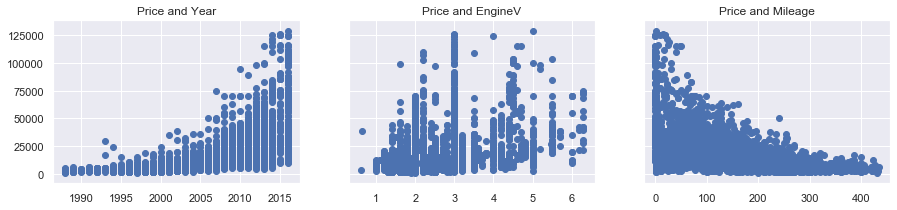

In [187]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'], data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

We can spot patterns but definitely not linear ones. We know we should not run a linear regression in this case. We should first transform one or more variables 

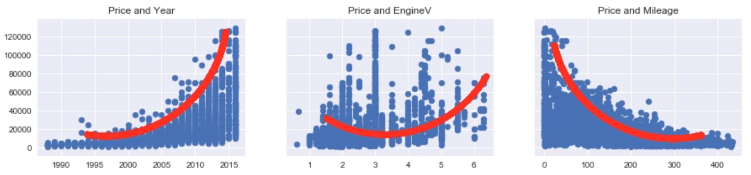

Recall the distribution plot of price to all these plot of price to all these plots are pointing us towards the idea that price is not normally distributed. And from there it's relationships with other rather normally distributed features is not linear. The patterns are quite exponential.

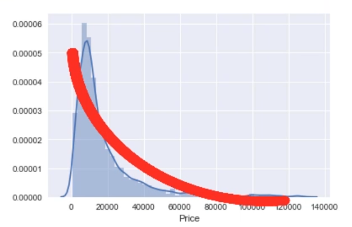

#### Log transformation

Log transformation is a common way to deal with this issue. It is especially useful when facing exponential relationships. 

In [188]:
log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price
data_cleaned.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,4200.00,sedan,277,2.00,Petrol,yes,1991,320,8.34
1,Mercedes-Benz,7900.00,van,427,2.90,Diesel,yes,1999,Sprinter 212,8.97
2,Mercedes-Benz,13300.00,sedan,358,5.00,Gas,yes,2003,S 500,9.50
3,Audi,23000.00,crossover,240,4.20,Petrol,yes,2007,Q7,10.04
4,Toyota,18300.00,crossover,120,2.00,Petrol,yes,2011,Rav 4,9.81


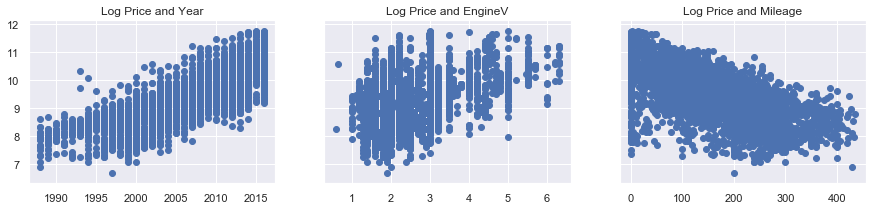

In [189]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'], data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')

plt.show()

We can see a linear pattern in all plots now. The lines fit the data so much better

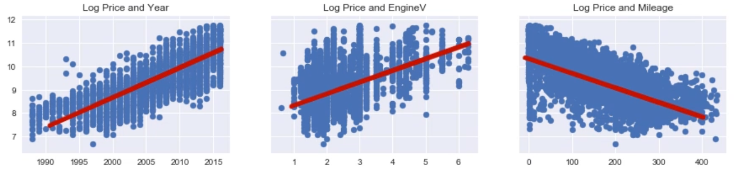

[]

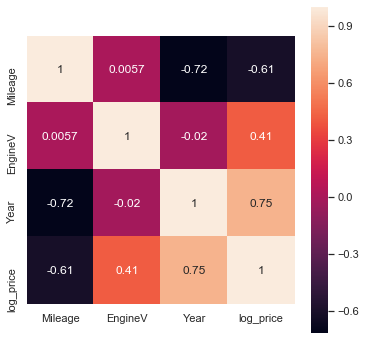

In [190]:
target_var = 'log_price'
corr = data_cleaned[num_vars + [target_var]].corr()
plt.figure(figsize = (6,6))
sns.heatmap(data = corr, annot = True, square = True, cbar = True)
plt.plot()

In [191]:
target = log_price
num_df = data_cleaned[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.8513076152080028
Test set:  0.8450649286479271
Year                                               Importance: 0.63
EngineV                                            Importance: 0.3
Mileage                                            Importance: 0.07


## 6.3. Create dummy variables

### All

If we have N categories for a feature, we have to create N-1 dummies. 

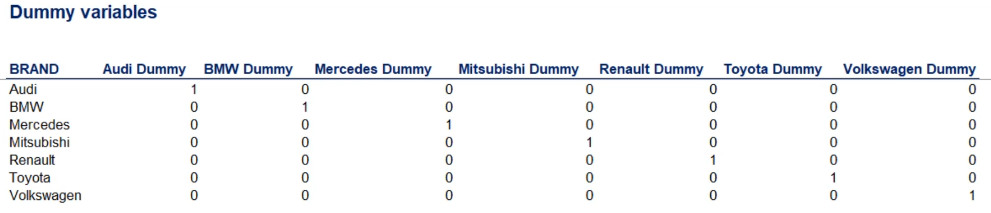

For the first brand we will not create a dummy variable. The reason is if all other dummy variables are zeros, it's clear that the car is an Audi. If we include a separate variable called Audi we will introduce multicolinearity to the regression as the Audi dummy would be perfectly determined by the other variables. Thus if we have n categories there will only be N minus one dummies 

In [192]:
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
cat_vars

['Brand', 'Body', 'Engine Type', 'Registration', 'Model']

#### Removing the first dummy

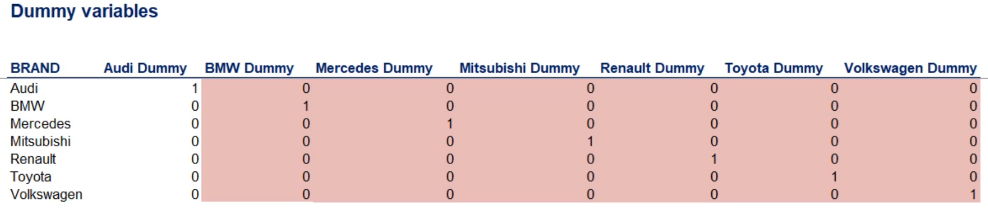

In [193]:
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
cat_df.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
cat_df.shape

(3867, 305)

In [195]:
target = log_price
num_df = data_cleaned[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.9358118297649403
Test set:  0.9289540388370539
Year                                               Importance: 0.57
EngineV                                            Importance: 0.23
Registration_yes                                   Importance: 0.07
Mileage                                            Importance: 0.05
Brand_Renault                                      Importance: 0.02
Brand_BMW                                          Importance: 0.01
Brand_Mercedes-Benz                                Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.01
Brand_Toyota                                       Importance: 0.0
Brand_Volkswagen                                   Importance: 0.0
Body_hatch                                         Importance: 0.0
Body_other                                         Importance: 0.0
Body_sedan                                         Importance: 0.0
Body_vagon                                         Importanc

### Brand

In [196]:
cat_vars = ['Brand']
cat_df = pd.get_dummies(data_cleaned[cat_vars])

print(cat_df.shape)
cat_df.head()

(3867, 7)


,Brand_Audi,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0


In [197]:
Predictive_Model(num_df, cat_df, target)

Train set:  0.8764462023969434
Test set:  0.8663458781367033
Year                                               Importance: 0.61
EngineV                                            Importance: 0.26
Mileage                                            Importance: 0.07
Brand_Renault                                      Importance: 0.02
Brand_BMW                                          Importance: 0.01
Brand_Mercedes-Benz                                Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.01
Brand_Audi                                         Importance: 0.0
Brand_Toyota                                       Importance: 0.0
Brand_Volkswagen                                   Importance: 0.0


In [198]:
cat_vars = ['Brand']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
print(cat_df.shape)
cat_df.head()

(3867, 6)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,1,0


In [199]:
Predictive_Model(num_df, cat_df, target)

Train set:  0.8741292445648504
Test set:  0.8651312204886328
Year                                               Importance: 0.61
EngineV                                            Importance: 0.27
Mileage                                            Importance: 0.07
Brand_Renault                                      Importance: 0.02
Brand_BMW                                          Importance: 0.01
Brand_Mercedes-Benz                                Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.01
Brand_Toyota                                       Importance: 0.0
Brand_Volkswagen                                   Importance: 0.0


### Body

In [200]:
cat_vars = ['Body']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

Train set:  0.8626868166021036
Test set:  0.8557450024778338
Year                                               Importance: 0.62
EngineV                                            Importance: 0.29
Mileage                                            Importance: 0.07
Body_sedan                                         Importance: 0.01
Body_vagon                                         Importance: 0.01
Body_van                                           Importance: 0.01
Body_hatch                                         Importance: 0.0
Body_other                                         Importance: 0.0


### Engine Type

In [201]:
cat_vars = ['Engine Type']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

Train set:  0.853916399458057
Test set:  0.848524841139796
Year                                               Importance: 0.63
EngineV                                            Importance: 0.29
Mileage                                            Importance: 0.07
Engine Type_Gas                                    Importance: 0.0
Engine Type_Other                                  Importance: 0.0
Engine Type_Petrol                                 Importance: 0.0


### Registration

In [202]:
cat_vars = ['Registration']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

Train set:  0.8976250449362707
Test set:  0.8951000572721786
Year                                               Importance: 0.6
EngineV                                            Importance: 0.26
Registration_yes                                   Importance: 0.07
Mileage                                            Importance: 0.06


### Model

In [203]:
cat_vars = ['Model']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

Train set:  0.8743274547175462
Test set:  0.8674039413116282
Year                                               Importance: 0.61
EngineV                                            Importance: 0.28
Mileage                                            Importance: 0.06
Model_Kangoo                                       Importance: 0.01
Model_100                                          Importance: 0.0
Model_11                                           Importance: 0.0
Model_116                                          Importance: 0.0
Model_118                                          Importance: 0.0
Model_120                                          Importance: 0.0
Model_19                                           Importance: 0.0
Model_190                                          Importance: 0.0
Model_200                                          Importance: 0.0
Model_210                                          Importance: 0.0
Model_220                                          Importance: 0

Train set:  0.8743274547175462
Test set:  0.8673298503425684
Year                                               Importance: 0.61
EngineV                                            Importance: 0.28
Mileage                                            Importance: 0.06
Model_Kangoo                                       Importance: 0.01
Model_100                                          Importance: 0.0
Model_11                                           Importance: 0.0
Model_116                                          Importance: 0.0
Model_118                                          Importance: 0.0
Model_120                                          Importance: 0.0
Model_19                                           Importance: 0.0
Model_190                                          Importance: 0.0
Model_200                                          Importance: 0.0
Model_210                                          Importance: 0.0
Model_220                                          Importance: 0

# GBT

### Declare the inputs and the targets

In [204]:
data_cleaned.columns

Index(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Model', 'log_price'],
      dtype='object')

In [205]:
num_df = data_cleaned[['Mileage','EngineV','Year']]
cat_df = data_cleaned[['Brand','Body','Engine Type','Registration']]

### Scale numerical features

In [206]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(num_df)
scaled_df = scaler.transform(num_df)
scaled_df = pd.DataFrame(scaled_df, columns = num_df.columns)
scaled_df.head()

,Mileage,EngineV,Year
0,1.22,-0.47,-2.57
1,2.79,0.47,-1.26
2,2.07,2.69,-0.61
3,0.83,1.84,0.05
4,-0.42,-0.47,0.70


### create dummy vars for categorical features

In [207]:
dummy_df = pd.get_dummies(cat_df, drop_first=True)
dummy_df.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


Note: it is not usually recommended to standardize dummy variables. In fact, many practitioners would argue strongly agains it

### Create preprocessed data

In [208]:
input_df = pd.concat([scaled_df,dummy_df],axis=1)
target = data_cleaned[['log_price']]

data_preprocessed = pd.concat([input_df,target],axis=1)
print(data_preprocessed.shape)
data_preprocessed.head()

(3867, 19)


,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes,log_price
0,1.22,-0.47,-2.57,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,8.34
1,2.79,0.47,-1.26,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,8.97
2,2.07,2.69,-0.61,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,9.50
3,0.83,1.84,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.04
4,-0.42,-0.47,0.70,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,9.81


### Train Test Split

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_df, target, test_size=0.2, random_state=365)

### Using sklearn

In [210]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [211]:
y_hat = model.predict(X_train)

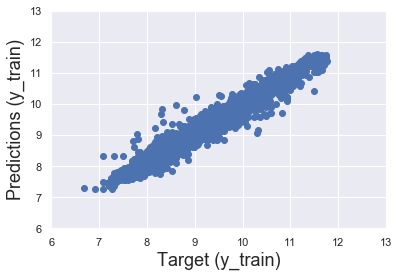

In [212]:
plt.scatter(y_train, y_hat)
plt.xlabel('Target (y_train)', size = 18)
plt.ylabel('Predictions (y_train)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

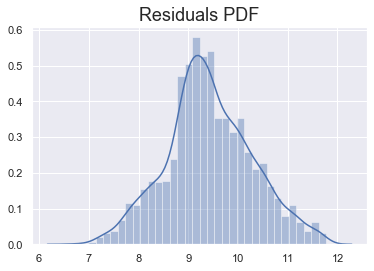

In [213]:
residuals = y_train['log_price'].values - y_hat
sns.distplot(y_train.values)
plt.title("Residuals PDF", size = 18)
plt.show()

In [214]:
model.score(X_train, y_train)

0.9305282868364994

In [215]:
model.score(X_test, y_test)

0.9228611602872059

In [216]:
    # Get numerical feature importance
    feature_importance = list(model.feature_importances_)
    feature_labels = X_train.columns
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_labels, feature_importance)]
    # Sort the feature importance by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importance 
    [print('{:50} Importance: {}'.format(*pair)) for pair in feature_importances];

Year                                               Importance: 0.57782
EngineV                                            Importance: 0.2339
Registration_yes                                   Importance: 0.07075
Mileage                                            Importance: 0.05566
Brand_Renault                                      Importance: 0.02298
Brand_Mercedes-Benz                                Importance: 0.01068
Brand_Mitsubishi                                   Importance: 0.00801
Brand_BMW                                          Importance: 0.00641
Body_van                                           Importance: 0.00477
Body_sedan                                         Importance: 0.00284
Brand_Volkswagen                                   Importance: 0.00273
Brand_Toyota                                       Importance: 0.00151
Body_other                                         Importance: 0.00065
Body_vagon                                         Importance: 0.00049
Engine 

### Testing

In [217]:
y_hat_test = model.predict(X_test)

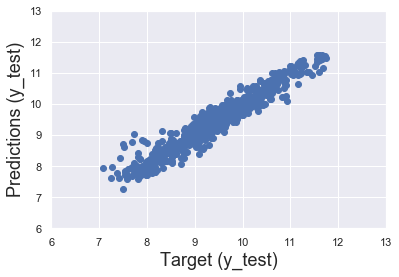

In [218]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Target (y_test)', size = 18)
plt.ylabel('Predictions (y_test)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

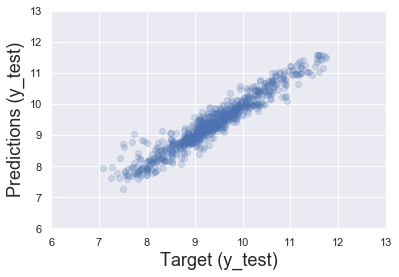

In [219]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Target (y_test)', size = 18)
plt.ylabel('Predictions (y_test)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [220]:
model.score(X_test, y_test)

0.9228611602872059

In [221]:
df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf.head()

,Prediction
0,9.03
1,7.97
2,7.59
3,8.81
4,8.99


In [222]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,8345.61
1,2901.74
2,1978.82
3,6717.50
4,8051.77


In [223]:
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Prediction,Target
0,8345.61,nan
1,2901.74,7900.00
2,1978.82,nan
3,6717.50,nan
4,8051.77,nan


In [224]:
y_test.head()

,log_price
1192,7.74
3360,7.94
2350,7.82
3257,8.76
892,9.12


In [225]:
y_test = y_test.reset_index(drop = True)
y_test.head()

,log_price
0,7.74
1,7.94
2,7.82
3,8.76
4,9.12


In [226]:
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Prediction,Target
0,8345.61,2300.00
1,2901.74,2800.00
2,1978.82,2500.00
3,6717.50,6400.00
4,8051.77,9150.00


In [227]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target'] * 100)
df_pf.head()

,Prediction,Target,Residual,Difference%
0,8345.61,2300.00,-6045.61,262.85
1,2901.74,2800.00,-101.74,3.63
2,1978.82,2500.00,521.18,20.85
3,6717.50,6400.00,-317.50,4.96
4,8051.77,9150.00,1098.23,12.00


In [228]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.00,774.00,774.00,774.00
mean,17482.09,18165.82,683.72,19.41
std,17936.63,19967.86,6034.04,23.28
min,1406.64,1200.00,-18888.93,0.02
25%,6706.25,6900.00,-1364.64,6.27
50%,11596.74,11600.00,118.87,14.59
75%,20232.67,20500.00,1764.91,24.63
max,105551.80,126000.00,48696.75,262.85


In [229]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
199,1950.49,1950.00,-0.49,0.02
651,2549.21,2550.00,0.79,0.03
74,2649.15,2650.00,0.85,0.03
708,11705.45,11700.00,-5.45,0.05
77,5703.12,5700.00,-3.12,0.05
554,3347.53,3350.00,2.47,0.07
716,13488.71,13500.00,11.29,0.08
386,8113.06,8100.00,-13.06,0.16
87,2404.46,2400.00,-4.46,0.19
666,104789.39,104999.00,209.61,0.20


## Tuning model